In [66]:
# execute to import notebook styling for tables and width etc.
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen('https://raw.githubusercontent.com/DataScienceUWL/DS775v2/master/ds755.css')
HTML(response.read().decode("utf-8"));

# computational imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, KNNBasic, SVD
from surprise.model_selection import cross_validate
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

<font size=18>Homework 11: Recommender Systems 2</font>

# **HW11.1** - Build a Baseline Model and Compute the RMSE

The file **rating_final.csv** (found in the presentation download for this lesson) contains user ratings for overall, food, and service for various restaurants.   

Do the following:

* display the first 5 lines of the data (get familiar with the data frame)
* For each row, make a a new combined rating by adding the rating, food_rating, and service_rating columns
* find the minimum combined restaurant rating
* find the maximum combined restaurant rating
* adjust the rating scale by shifting up 1 if 0 is included
* calculate the mean restaurant rating for all restaurant (just to get an idea)
* drop the ratings for food and service so that only the overall combined rating remains (If you did this as an extra column, then drop rating, too. If you overwrote the rating column, then keep it. You should end up with a dataframe that just has userID, placeID, and rating)
* split the data set so that 80\% of a users ratings are in the training set and 20\% are in the testing set
* build a baseline model that assigns the appropriate rating (median of all data) for all predictions and compute the RMSE of these on the testing set
* make sure that your score function and models are not using global variables. Pass in all data that you need using \*args if need be

Click <a href = https://www.kaggle.com/uciml/restaurant-data-with-consumer-ratings> here </a> or <a href = https://archive.ics.uci.edu/ml/datasets/Restaurant+%26+consumer+data> here </a> for more details about the data set.

<font color = "blue"> *** 12 points -  answer in cells below *** (don't delete this cell) </font>

In [45]:
# enter your code here

# read in data
ratings = pd.read_csv("data/restaurant/rating_final.csv")

# combined rating
ratings['combined'] = ratings['rating'] + ratings['food_rating'] + ratings['service_rating']

# get boundaries
min_rating = min(ratings['combined'])
max_rating = max(ratings['combined'])
print(ratings.head())
print(f"Minimum combined rating: {min_rating}")
print(f"Maximum combined rating: {max_rating}")

# shift scale to remove 0's
ratings[['rating', 'food_rating', 'service_rating', 'combined']] += 1
min_rating = min(ratings['combined'])
max_rating = max(ratings['combined'])
print(f"\nShifted minimum combined rating: {min_rating}")
print(f"Shifted maximum combined rating: {max_rating}")

# Mean combined rating
print(f"\nMean shifted combined rating: {np.mean(ratings['combined'])}\n")

# Drop cols
ratings = ratings[['userID', 'placeID', 'combined']]

print("-------------------------------------------\n")


#Assign X as the original ratings dataframe and y as the userID column of ratings.
X = ratings.copy()
y = ratings['userID']

#Split into training and test datasets, stratified along user_id
# Had to keep your Douglas Adams shout-out in there...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

print(f"Training set: {len(X_train)} ratings\nTest set: {len(X_test)} ratings\n")

#first determine the median of our ratings (we could have done this by hand, but numpy does it so well... )
print(f"The median of this rating range is {np.median(np.arange(np.min(ratings['combined']), (np.max(ratings['combined']) + 1)))}")

#define a baseline model to always return the median
def baseline(userID, placeID, *args):
    return 4.0

#Function to compute the RMSE score obtained on the testing set by a model
def score(cf_model, X_test, *args):
    
    #Construct a list of user-restaurant tuples from the testing dataset
    id_pairs = zip(X_test['userID'], X_test['placeID'])
    
    #Predict the rating for every user-restaurant tuple
    y_pred = np.array([cf_model(user, place, *args) for (user, place) in id_pairs])
    
    #Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test['combined'])
    
    #Return the final RMSE score
    return mean_squared_error(y_true, y_pred, squared=False)
                              
#let's test it with our baseline model
base_score = score(baseline, X_test)
print(f"\nBaseline score: {base_score}\n")


  userID  placeID  rating  food_rating  service_rating  combined
0  U1077   135085       2            2               2         6
1  U1077   135038       2            2               1         5
2  U1077   132825       2            2               2         6
3  U1077   135060       1            2               2         5
4  U1068   135104       1            1               2         4
Minimum combined rating: 0
Maximum combined rating: 6

Shifted minimum combined rating: 1
Shifted maximum combined rating: 7

Mean shifted combined rating: 4.505598621877692

-------------------------------------------

Training set: 928 ratings
Test set: 233 ratings

The median of this rating range is 4.0

Baseline score: 2.135938145091438



# **HW11.2** - Build a Weighted Mean User-Based Filter

From data in the file **rating_final.csv**, build a ratings matrix from the data frame of users, places, and restaurant ratings and build a user-based collaborative filtering model that weights mean rank using cosine similarity among users.  Fit the model on the training set and compute the RMSE for this model using the test set and compare it to the RMSE of the baseline model.  Is it better than baseline?  (*i.e.* is the RMSE smaller?)

<font color = "blue"> *** 12 points -  answer in cells below *** (don't delete this cell) </font>

In [64]:
#Build the ratings matrix using pivot_table function
r_matrix = X_train.pivot_table(values='combined', index='userID', columns='placeID')

#Create a dummy ratings matrix with all null values imputed to 0
r_matrix_dummy = r_matrix.copy().fillna(0)

#Compute the cosine similarity matrix using the dummy ratings matrix
cosine_sim = cosine_similarity(r_matrix_dummy, r_matrix_dummy)

#Convert into pandas dataframe 
cosine_sim = pd.DataFrame(cosine_sim, index=r_matrix.index, columns=r_matrix.index)

#User Based Collaborative Filter using Weighted Mean Ratings
def cf_user_wmean(userID, placeID, ratings_matrix, c_sim_matrix):
    
    #Check if placeID exists in r_matrix
    if placeID in ratings_matrix:
        
        #Get the similarity scores for the user in question with every other user
        sim_scores = c_sim_matrix[userID]
        
        #Get the user ratings for the restaurant in question
        r_ratings = ratings_matrix[placeID]
        
        #Extract the indices containing NaN in the r_ratings series
        idx = r_ratings[r_ratings.isnull()].index
        
        #Drop the NaN values from the r_ratings Series
        r_ratings = r_ratings.dropna()
        
        #Drop the corresponding cosine scores from the sim_scores series
        sim_scores = sim_scores.drop(idx)
        
        #Compute the final weighted mean
        if sim_scores.sum() == 0:
            wmean_rating = 4.0
        else:
            wmean_rating = np.dot(sim_scores, r_ratings)/ sim_scores.sum()

    else:
        #Default to a rating of 4.0 in the absence of any information
        wmean_rating = 4.0
    
    return wmean_rating

score(cf_user_wmean, X_test, r_matrix, cosine_sim)

2.3135820281130606

# **HW11.3** - Build a kNN-Based Collaborative Filter

**Use a np.random seed of 1 for this problem.**

From data in the file **rating_final.csv**, use the *surprise* library in Python to build an kNN-based collaborative filtering model for the restaurant ratings.  Use five-fold cross-validation to train the model on the entire dataset using the following values for k:

nums = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37]

Use matplotlib and seaborn to plot the results of the various k values. (Review Banik's Chapter 5 if this is unfamiliar.)

Which value of k should you use for the kNN-Based Collaborative Filter?



<font color = "blue"> *** 12 points -  answer in cells below *** (don't delete this cell) </font>

The lowest mean RMSE of 2.1108864061121 is obtained when k = 7.



Text(6.4, 2.109, 'k = 7')

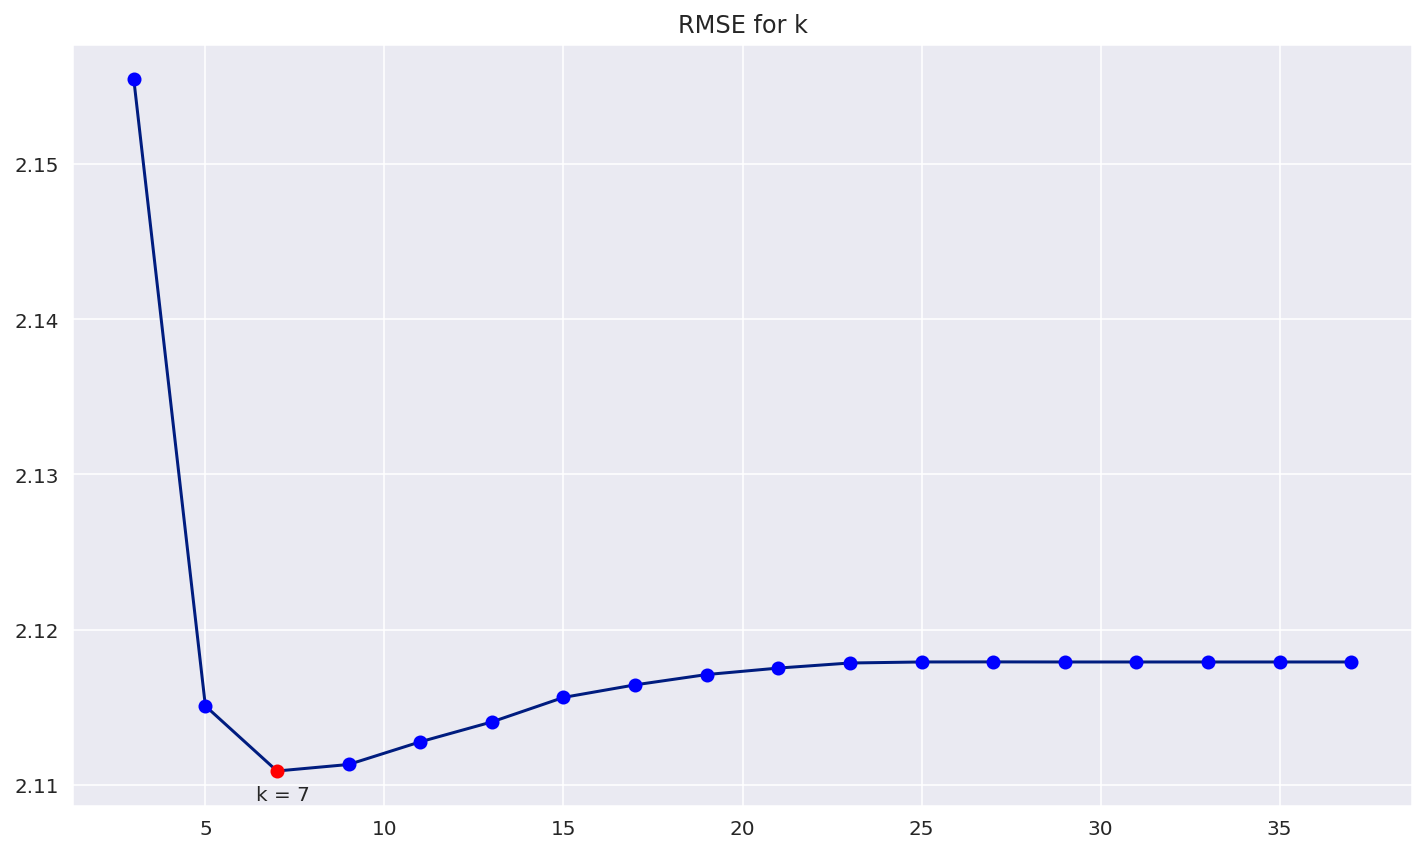

In [139]:
# possible values of k
nums = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37]

# dict to store k:rmse
k_rmse = dict(zip(nums, np.zeros(len(nums))))

# Define a Reader object
reader = Reader(rating_scale=(1,7))

#Create the dataset to be used for building the filter
data = Dataset.load_from_df(ratings, reader)

for num in nums:
   
    #define a random seed for consistent results
    np.random.seed(1)
    
    #Define the algorithm object; in this case kNN
    knn = KNNBasic(k=num, verbose=False) 

    # CV
    knn_cv = cross_validate(knn, data, measures=['RMSE'], cv=5, verbose=False)
    
    #to extract the mean RMSE, we need to get the mean of the test_rmse values
    knn_RMSE = np.mean(knn_cv['test_rmse'])
    
    # store k:rmse
    k_rmse[num] = knn_RMSE
    

# Results
best_k = min(k_rmse, key=k_rmse.get)
best_rmse = k_rmse[best_k]
print(f"The lowest mean RMSE of {best_rmse} is obtained when k = {best_k}.\n")

# Chart
keys = list(k_rmse.keys())
vals = [k_rmse[k] for k in k_rmse.keys()]
import warnings # come on, seaborn
warnings.simplefilter(action="ignore", category=FutureWarning)
sns.set_palette("dark")
ax = sns.lineplot(keys, vals)
ax.set(title = "RMSE for k")
for k in keys:
    if k == 7:
        plt.plot(k,k_rmse[k], 'ro')
    else:
        plt.plot(k,k_rmse[k], 'bo')
plt.text(x = 6.4, y = 2.109, s = 'k = 7')


# **HW11.4** - Build a Hybrid Filter

From ratings data you have already loaded (including the merging of ratings and adjustments for zero-base) and **geoplaces2.csv** build a recommender system that is a hybrid of a metadata content-based recommender and a predictive collaborative filter.  Your recommender should do the following:


**SETUP**
* Retrain the KNN filter using the k-value you found in the previous question.
* Train an SVD filter using the same data set you used for the KNN filter.

* Create a function that takes in a user ID, restaurant name and any other required data as user input (follow the lesson examples and avoid using global variables).
* Use a metadata content-based model to compute the 25 most similar restaurants based on cosine similarity from the following details (create a soup as done for the content-based recommender from Lesson 10)
    - price
    - dress code
    - accessibility
    - ambiance
    - alcohol
    - smoking area
* Compute the predicted ratings that the user might give to these 25 restaurants using the passed-in predictive model.
* Have your function return the top 10 restaurant recommendations including price, dress code, accessibility, ambiance, alcohol, and smoking area and predicted rating.


**Running the code**

Call your function the following ways:
* user **U1077**, restaurant named **cafe ambar**, using the SVD predictor and the KNN predictor.
* user **U1065**, restaurant named **cafe ambar**,  using the SVD predictor and the KNN predictor.

(You will call your function 4 times and output 4 dataframes.)

Comment on the similarities and differences in the resulting recommendations. 

**Use a np.random seed of 1 for this problem.**

*Note 1: This data set does not have the issue of having two different ID's in separate files for each restaurant like the movie data used in the textbook example, so you won't need to use the cell for mapping ID's to titles.*

*Note 2: because of the small number of words in the "soup", many of the restaurant pairs have a cosine similarity of 1, which will affect the predicted ratings and recommendations. Make sure you use the demonstrated method of using del to remove the restaurant's own cosine score instead of relying on it being the first item in the sorted array.* 

<font color = "blue"> *** 14 points -  answer in cells below *** (don't delete this cell) </font>

In [231]:
# Define a Reader object
reader = Reader(rating_scale=(1,7))

#Create the dataset to be used for building the filter
data = Dataset.load_from_df(ratings, reader)

#######################################
#              k-NN                   #
#######################################

#define a random seed for consistent results
np.random.seed(1)

#Define the algorithm object; in this case kNN
knn = KNNBasic(k=7, verbose=False) 

# CV
knn_cv = cross_validate(knn, data, measures=['RMSE'], cv=5, verbose=False)

#to extract the mean RMSE, we need to get the mean of the test_rmse values
knn_RMSE = np.mean(knn_cv['test_rmse'])

#######################################
#                SVD                  #
#######################################
                   
#define a random seed for consistent results
np.random.seed(1)

#Define the SVD algorithm object
svd = SVD()

#Evaluate the performance in terms of RMSE
svd_cv = cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=False)

#to extract the mean RMSE, we need to get the mean of the test_rmse values
svd_RMSE = np.mean(svd_cv['test_rmse'])


#######################################
#          Cosine Similarity          #
#######################################

# read in data
geoplaces = pd.read_csv("data/restaurant/geoplaces2.csv")

# drop columns
geoplaces['Ambiance'] = geoplaces['Rambience']
geoplaces = geoplaces[['placeID', 'name', 'price', 'dress_code', 'accessibility', 'Ambiance', 'alcohol', 'smoking_area']]

# make soup
geoplaces['soup'] = geoplaces['price'] + " " + geoplaces["dress_code"] + " " + geoplaces['accessibility'] + " " + geoplaces['Ambiance'] + " " + geoplaces['alcohol'] + " " + geoplaces['smoking_area']

# use CountVectorizer to build count matrix from geoplaces and then cosine similarity matrix
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(geoplaces['soup'])

#Compute the cosine similarity score 
cosine_sim = cosine_similarity(count_matrix, count_matrix)

# Convert into pandas dataframe 
cosine_sim = pd.DataFrame(cosine_sim, index=geoplaces['name'], columns=geoplaces['name'])

#######################################
#          Hybrid Recommender         #
#######################################

def hybrid(user_id, name, cosine_matrix, data, predictor):
    
    #get column index from column name in the cosine_matrix
    idx = cosine_matrix.columns.get_loc(name) 
    
    #Extract the similarity scores and their corresponding index for every item from the cosine_sim matrix
    sim_scores = list(enumerate(cosine_matrix[name]))
    
    #excluding the similarity score of the item with itself
    del sim_scores[idx]
    
    #Sort the (index, score) tuples in decreasing order of similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    #Select the top 25 tuples
    sim_scores = sim_scores[0:25]
    
    #Store the cosine_sim indices of the top 25 items in a list
    item_indices = [i[0] for i in sim_scores]
    
    #Extract the metadata of the aforementioned items
    items = data.iloc[item_indices][['name']]
    
    items['Price'] = data['price']
    items['Dress Code'] = data['dress_code']
    items['Accessibility'] = data['accessibility']
    items['Ambiance'] = data['Ambiance']
    items['Alcohol'] = data['alcohol']
    items['Smoking Area'] = data['smoking_area']
    
    #Compute the predicted ratings using the SVD or k-NN filter
    items['Predicted Rating'] = data['placeID'].apply(lambda x: predictor.predict(user_id, x).est)
    
    #Sort the items in decreasing order of predicted rating
    items = items.sort_values('Predicted Rating', ascending=False)
    
    #Return the top 10 items as recommendations
    return items.head(10)

print(f"U1077 - SVD:\n {hybrid('U1077', 'cafe ambar', cosine_sim, geoplaces, svd)}\n")
print(f"U1077 - k-NN:\n {hybrid('U1077', 'cafe ambar', cosine_sim, geoplaces, knn)}\n")
print(f"U1065 - SVD:\n {hybrid('U1065', 'cafe ambar', cosine_sim, geoplaces, svd)}\n")
print(f"U1065 - k-NN:\n {hybrid('U1065', 'cafe ambar', cosine_sim, geoplaces, knn)}\n")


U1077 - SVD:
                                name Price Dress Code     Accessibility  \
24                        Giovannis   low   informal  no_accessibility   
107                         Log Yin   low   informal  no_accessibility   
1                   puesto de tacos   low   informal        completely   
43                          churchs   low   informal        completely   
3    little pizza Emilio Portes Gil   low   informal        completely   
93               tacos los volcanes   low   informal        completely   
73                       palomo tec   low   informal        completely   
87                  Rincon Huasteco   low   informal        completely   
86    Carreton de Flautas y Migadas   low   informal        completely   
29                     don burguers   low   informal  no_accessibility   

     Ambiance            Alcohol Smoking Area  Predicted Rating  
24   familiar  No_Alcohol_Served         none          5.531467  
107  familiar  No_Alcohol_Served       

The recommendations seem reasonable.  There are similarities between the restaurants.  They all seem to be low-price, casual restaurants.  There are differences between the recommendations for each user, indicating that their previous ratings mattered.  I think it worked.